# Support Vector Machine with OSQP

In this exercise, we will implement a Support Vector Machine (SVM) using the OSQP (Operator Splitting Quadratic Program) solver. We will focus on the Radial Basis Function (RBF) kernel and visualize the decision boundary and support vectors.

## Objectives
- Implement SVM with an RBF kernel using OSQP.
- Solve the SVM optimization problem.
- Compute the decision boundary and support vectors.
- Visualize the results.

## Step 1: Import Libraries

We will begin by importing the necessary libraries. JAX will be used for numerical computations, OSQP for optimization, and Matplotlib for visualization.

In [1]:
# Importing required libraries
import jax
import jax.numpy as jnp
from jaxopt import BoxOSQP

import numpy as np
from sklearn import datasets
from sklearn import preprocessing
import matplotlib.pyplot as plt

## Step 2: Define the RBF Kernel

The Radial Basis Function (RBF) kernel is defined as follows:
$$ K(x, y) = \exp(-\gamma \|x - y\|^2) $$

Where $ \gamma $ is a parameter that determines the spread of the kernel. We will implement this kernel as a function.

In [2]:
def rbf_kernel(X1, X2, gamma):
    # This must work when X1 and X2 are matrices
    sq_dists = -2 * jnp.dot(X1, X2.T) + jnp.sum(X1**2, axis=1)[:, None] + jnp.sum(X2**2, axis=1)
    return jnp.exp(-gamma * sq_dists)

## Step 3: Define the SVM Optimization with OSQP

The objective of the Support Vector Machine (SVM) is to find a hyperplane that separates data points of different classes with the maximum margin. The formulation of the SVM optimization problem can be derived as follows:

### Dual Problem

The dual form of the SVM optimization problem is derived from the primal problem using dual coefficients (see Representer Theorem). The dual problem is given by:

$$
\begin{aligned}
& \text{minimize} && \frac{1}{2} \beta^T K \beta - \beta^T \mathbf{y}  \\
& \text{subject to} && \sum_{i=1}^{n} \beta_i = 0 \\
& && -C \leq \beta_i \leq 0, \quad \forall i \text{ if } y_i =-1\\
& && 0 \leq \beta_i \leq C, \quad \forall i \text{ if } y_i =1
\end{aligned}
$$

Where:
- $ \beta_i $ are the dual coefficients.
- $ K(X_i, X_j) $ is the kernel function, which in our case is the Radial Basis Function (RBF) kernel defined as:
  
$$
K(X_i, X_j) = \exp(-\gamma \|X_i - X_j\|^2)
$$

### OSQP Formulation

In the context of OSQP, we reformulate the dual problem in terms of matrix-vector products for efficient computation. The dual optimization problem is rewritten as:

1. **Quadratic Objective**:

   $$
   \text{minimize} \quad \frac{1}{2} \mathbf{\beta}^T K \mathbf{\beta} - \mathbf{y}^T \mathbf{\beta}
   $$


2. **Linear Constraints**:

   $$
   A \mathbf{\beta} = \mathbf{z}
   $$
   
   $$
   l \leq \mathbf{z} \leq u
   $$

   Where:
   - $ A $ is the constraint matrix.
   - $ l $ and $ u $ are the lower and upper bounds for $ \beta_i $, derived from the constraints of the dual problem.

By using the OSQP solver, we can efficiently solve this quadratic program to obtain the optimal values of $ \beta $, which can then be used to compute the weight vector $ \beta $ and the bias $ b $ for classification.

In our case we have that 
- $A$: is the identity
- We implement the equality constraint on the sum of $\beta$ as $0 \leq \sum_{i=0}^n \beta_i \leq 0$


In [3]:
def binary_kernel_svm_osqp(X, y, C, gamma):
    K = rbf_kernel(X, X, gamma)

    # 0.5 beta^T K beta 
    def matvec_Q(Q, beta):
        return jnp.dot(Q, beta)

    # return beta and the sum of betas, for the constrait
    def matvec_A(_, beta):
        return beta, jnp.sum(beta)

    # first element of the tuple is the elementwise constraint on \beta_i
    # second element of the tuple is the constraint on the sum of betas
    # the tuple has size two like the size of the tuple returned by `matvec_A`
    l = -jax.nn.relu(-y * C), 0.
    u = jax.nn.relu(y * C), 0.

    # build and run the optimizer
    osqp = BoxOSQP(matvec_Q=matvec_Q, matvec_A=matvec_A, tol=1e-6)
    params, _ = osqp.run(
        init_params=None,
        params_obj=(K, -y), # parameters passed to `matvec_Q` and used for `y^T \beta`
        params_eq=None,
        params_ineq=(l, u)
    )
    beta = params.primal[0]

    return beta

## Step 4: Compute the Bias Term

The bias term $b$ is computed using one of the support vectors. The formula used is:

$$ b = y_i - \sum_{j} \beta_j K(x_j, x_i) $$

Where $i$ is the index of a support vector.

In [4]:
def compute_bias(X, y, beta, gamma):
    # Compute the bias term b by using a support vector
    support_indices = jnp.where(jnp.abs(beta) > 1e-4)[0]
    if len(support_indices) > 0:
        i = support_indices[0]
        # https://stats.stackexchange.com/questions/451868/calculating-the-value-of-b-in-an-svm
        # the loop on SV is equivalent to a loop on all betas since beta is almost 0
        return y[i]-jnp.sum(beta[support_indices] * rbf_kernel(X[support_indices], X[i:i+1], gamma).reshape((-1,)))
    else:
        return 0.

## Step 5: Decision Function

The decision function computes the predicted output for a test point as follows:
$$ \hat{y}_i = \sum_{i} \beta_i y_i K(x_i, x) + b $$

Where $ x_i $ are the support vectors.

In [5]:
def decision_function(X_train, y_train, X_test, beta, gamma, b):
    K_test = rbf_kernel(X_test, X_train, gamma=gamma)
    b = compute_bias(X_train, y_train, beta, gamma=gamma)
    return K_test @ beta + b

## Step 6: Prepare the Dataset

We will generate a circular dataset using the `make_circles` function from Scikit-learn, scale the data, and transform the labels to \{-1, 1\}.

In [10]:
num_samples = 30
lam = 0.001
gamma = 0.5  # Gamma parameter for RBF kernel

np.random.seed(0)

# Prepare circular dataset
X, y = datasets.make_circles(n_samples=num_samples, factor=0.5, noise=0.05)  # Circle data
X = preprocessing.StandardScaler().fit_transform(X)  # Scale data
y = jnp.array(y * 2. - 1.)  # Transform labels from {0, 1} to {-1., 1.}

C = 1. / 2 / lam / num_samples

## Step 7: Train the SVM Model

Now we will solve the SVM optimization problem using OSQP and display the results.

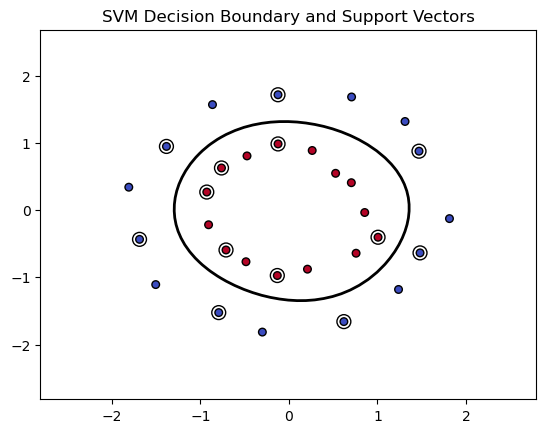

In [7]:
# Solve with OSQP
beta = binary_kernel_svm_osqp(X, y, C, gamma)

# Create a grid of points to evaluate the decision function
h = .1  # Step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Compute the decision function for each point in the grid
X_test = jnp.c_[xx.ravel(), yy.ravel()] # `ravel` is like `flatten` but with a caveat, search it in the docs!
b = compute_bias(X, y, beta, gamma=0.5)
Z = decision_function(X, y, X_test, beta, 0.5, b)
Z = Z.reshape(xx.shape)

# Plot the decision boundary and margins
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')  # Decision boundary

# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k')

support_vectors = jnp.where(jnp.abs(beta) > 1e-4)[0]
# Highlight the support vectors
plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=100, facecolors='none', edgecolors='k')

plt.title("SVM Decision Boundary and Support Vectors")
plt.show()

### Comparison with Scikit-Learn

In [8]:
from sklearn import svm

K = rbf_kernel(X, X, gamma)  # Compute RBF kernel matrix
svc = svm.SVC(kernel="precomputed", C=C, tol=1e-6).fit(K, y)
beta_sk = np.zeros(K.shape[0])
beta_sk[svc.support_] = svc.dual_coef_[0]
Z_sk = svc.decision_function(rbf_kernel(X_test, X, gamma=gamma))

print(f"Beta discrepancy       {np.max(np.abs(beta_sk - beta)):.3e}")
print(f"Intercept discrepancy  {np.max(np.abs(svc.intercept_ - b)):.3e}")
print(f"Prediction discrepancy {np.max(np.abs(Z_sk - Z.flatten())):.3e}")


Beta discrepancy       3.934e-05
Intercept discrepancy  1.431e-06
Prediction discrepancy 2.861e-06
